#  Part 1: Setup & Installation



In [1]:
# Install required libraries
!pip install torch deap opencv-python tqdm scikit-learn matplotlib --quiet
!pip install deap

# Imports
import os
import cv2
import numpy as np
from tqdm import tqdm
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import zipfile
import tarfile
import time
import pickle

# Set seed
np.random.seed(42)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 12.6 MB/s eta 0:00:00


# Part 2: Dataset Download

In [2]:
# Clean previous data
!rm -rf 101_ObjectCategories
!rm -f caltech-101.zip

# Download Caltech-101 dataset
!wget -q -O caltech-101.zip https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip

# Extract .zip
with zipfile.ZipFile('caltech-101.zip', 'r') as zip_ref:
    for file in zip_ref.namelist():
        if not file.startswith('__MACOSX/'):
            try:
                zip_ref.extract(file, path='.')
            except:
                pass

# Extract inner .tar.gz
with tarfile.open('caltech-101/101_ObjectCategories.tar.gz', 'r:gz') as tar_ref:
    tar_ref.extractall(path='.')

# Part 3: Dataset Loader

In [3]:
import concurrent.futures
import os
import cv2

# Function to load a single image
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        return cv2.resize(img, (140, 140))
    return None

# Function to load class images
def load_class_images(class_name, max_images=50, include_negatives=True):
    base_path = "101_ObjectCategories"
    pos_images, neg_images = [], []

    pos_folder = next((f for f in os.listdir(base_path) if f.lower() == class_name.lower()), None)
    if pos_folder:
        pos_path = os.path.join(base_path, pos_folder)
        image_paths = [os.path.join(pos_path, img_file)
                       for img_file in os.listdir(pos_path)[:max_images]
                       if img_file.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Use parallel processing to load images
        with concurrent.futures.ThreadPoolExecutor() as executor:
            pos_images = [img for img in executor.map(load_image, image_paths) if img is not None]

    if include_negatives:
        neg_folder = "BACKGROUND_Google"
        neg_path = os.path.join(base_path, neg_folder)
        if os.path.exists(neg_path):
            neg_samples = min(3 * len(pos_images), 3 * max_images)
            neg_image_paths = [os.path.join(neg_path, img_file)
                               for img_file in os.listdir(neg_path)[:neg_samples]
                               if img_file.lower().endswith(('.png', '.jpg', '.jpeg'))]

            # Use parallel processing to load negative images
            with concurrent.futures.ThreadPoolExecutor() as executor:
                neg_images = [img for img in executor.map(load_image, neg_image_paths) if img is not None]

    min_samples = min(len(pos_images), len(neg_images))
    if min_samples == 0:
        print(f"Warning: No samples for {class_name}")
        return None, None

    images = pos_images[:min_samples] + neg_images[:min_samples]
    labels = [1] * min_samples + [0] * min_samples
    return images, labels

# Load classes
airplane_images, airplane_labels = load_class_images("airplanes")
car_images, car_labels = load_class_images("car_side")
face_images, face_labels = load_class_images("faces_easy")

# Keep only successful ones
classes = {
    k: v for k, v in {
        'Airplane': (airplane_images, airplane_labels),
        'Car': (car_images, car_labels),
        'Face': (face_images, face_labels)
    }.items() if v[0] is not None
}


#Part 3: HMAX Layers (S1 → C1 → S2 → C2)

In [13]:
import numpy as np
import cv2
import random
import os
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from deap import base, creator, tools, algorithms
from functools import partial

# ======================
# S1 & C1 Layers
# ======================
def gabor_filter_bank(scales=16, orientations=4):
    filters = []
    ksize_range = np.linspace(7, 37, scales, dtype=int)
    theta_vals = np.linspace(0, np.pi, orientations, endpoint=False)
    for ksize in ksize_range:
        for theta in theta_vals:
            kernel = cv2.getGaborKernel(
                (ksize, ksize), sigma=ksize / 5, theta=theta,
                lambd=ksize / 2, gamma=0.5, psi=0, ktype=cv2.CV_32F
            )
            filters.append(kernel)
    return filters

def apply_s1_filters(image, filters):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return [cv2.filter2D(gray, cv2.CV_32F, gabor) for gabor in filters]

def apply_c1_layer(s1_outputs, scales_per_band=2):
    c1_outputs = []
    num_bands = len(s1_outputs) // scales_per_band
    for i in range(num_bands):
        max_map = np.maximum(s1_outputs[2*i], s1_outputs[2*i + 1])
        pooled = cv2.resize(max_map, (max_map.shape[1] // 4, max_map.shape[0] // 4))
        c1_outputs.append(pooled)
    return c1_outputs

# ======================
# S2 & C2 Layers
# ======================
def extract_random_patches(c1_outputs, patch_sizes=[4, 8, 12, 16], num_patches=100):
    patches = []
    for _ in range(num_patches):
        band = c1_outputs[np.random.randint(len(c1_outputs))]
        size = np.random.choice(patch_sizes)
        if band.shape[0] < size or band.shape[1] < size:
            continue
        y = np.random.randint(0, band.shape[0] - size)
        x = np.random.randint(0, band.shape[1] - size)
        patch = band[y:y + size, x:x + size]
        if patch.shape == (size, size):
            patches.append(patch.flatten())
    return patches

def compute_c2_features(c1_outputs, patches):
    features = []
    for patch in patches:
        patch_size = int(np.sqrt(len(patch)))
        min_dist = float('inf')
        for band in c1_outputs:
            for y in range(band.shape[0] - patch_size + 1):
                for x in range(band.shape[1] - patch_size + 1):
                    region = band[y:y + patch_size, x:x + patch_size]
                    if region.shape == (patch_size, patch_size):
                        dist = np.linalg.norm(region.flatten() - patch)
                        min_dist = min(min_dist, dist)
        features.append(min_dist)
    return features

# ======================
# Genetic Algorithm Setup
# ======================
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def eval_features(individual, X_train_c1, y_train, X_val_c1, y_val, all_patches):
    selected_patches = [all_patches[i] for i in individual]
    train_feats = [compute_c2_features(c1, selected_patches) for c1 in X_train_c1]
    val_feats = [compute_c2_features(c1, selected_patches) for c1 in X_val_c1]

    clf = SVC(kernel='linear')
    clf.fit(train_feats, y_train)
    acc = clf.score(val_feats, y_val)
    return (acc,)

def run_genetic_algorithm(X_train_c1, y_train, X_val_c1, y_val, all_patches, generations=5, pop_size=5):
    patch_indices = list(range(len(all_patches)))
    toolbox = base.Toolbox()
    toolbox.register("attr_int", random.choice, patch_indices)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=10)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", partial(eval_features,
                                         X_train_c1=X_train_c1, y_train=y_train,
                                         X_val_c1=X_val_c1, y_val=y_val,
                                         all_patches=all_patches))
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=generations,
                        stats=None, halloffame=hof, verbose=True)
    best_indices = hof[0]
    best_patches = [all_patches[i] for i in best_indices]
    return best_patches

# ======================
# Model Evaluation Function
# ======================
def evaluate_model(images, labels, patch_sizes=[4, 8, 12, 16], training_sizes=[ 30, 40], save_path=None):
    baseline_scores = []
    optimized_scores = []
    completed_indices = set()

          # Try to load existing progress
    if save_path and os.path.exists(save_path):
        try:
            print("Resuming from saved results...")
            with open(save_path, 'rb') as f:
                saved_ts, baseline_scores, optimized_scores = pickle.load(f)
            # Handle mismatch in saved training sizes
            completed_indices = set(i for i, ts in enumerate(training_sizes) if ts in saved_ts)
        except Exception as e:
            print(f" Failed to load save file ({e}), starting fresh...")
            baseline_scores, optimized_scores = [], []
            completed_indices = set()
    else:
        print(" No saved results found. Starting fresh.")
        baseline_scores, optimized_scores = [], []
        completed_indices = set()

    # Consistent train-test split
    X_train_img, X_test_img, y_train, y_test = train_test_split(
        images, labels, test_size=0.5, stratify=labels, random_state=42)

    # Gabor filters + C1 features
    filters = gabor_filter_bank()
    print("→ Applying Gabor filters and caching C1 features...")
    X_train_c1 = [apply_c1_layer(apply_s1_filters(img, filters)) for img in X_train_img]
    X_test_c1 = [apply_c1_layer(apply_s1_filters(img, filters)) for img in X_test_img]

    total_cases = len(training_sizes)
    for i, N in enumerate(training_sizes):
        if i in completed_indices:
            print(f"Skipping already-completed case: {N} samples")
            continue

        print(f"\n[{int((i + 1) / total_cases * 100)}%] Training with {N} positive samples")

        pos_idx = [j for j, l in enumerate(y_train) if l == 1][:N]
        neg_idx = [j for j, l in enumerate(y_train) if l == 0][:3 * N]
        train_idx = pos_idx + neg_idx

        X_train_subset = [X_train_c1[j] for j in train_idx]
        y_train_subset = [y_train[j] for j in train_idx]

        stratify = y_train_subset if len(set(y_train_subset)) >= 2 and min([y_train_subset.count(c) for c in set(y_train_subset)]) > 1 else None
        X_train_inner, X_val_inner, y_train_inner, y_val_inner = train_test_split(
            X_train_subset, y_train_subset, test_size=0.4, stratify=stratify, random_state=42)

        print("→ Extracting patches...")
        all_patches = []
        for c1 in X_train_subset:
            all_patches.extend(extract_random_patches(c1, patch_sizes=patch_sizes, num_patches=10))

        print("→ Computing C2 features for baseline...")
        baseline_train_feats = [compute_c2_features(c1, all_patches) for c1 in X_train_subset]
        baseline_test_feats = [compute_c2_features(c1, all_patches) for c1 in X_test_c1]

        print("→ Training SVM for baseline...")
        clf = SVC(kernel='linear')
        clf.fit(baseline_train_feats, y_train_subset)
        acc = clf.score(baseline_test_feats, y_test)
        baseline_scores.append(acc)
        print(f"   Baseline accuracy: {acc:.2f}")

        print("→ Running Genetic Algorithm for optimized patches...")
        best_patches = run_genetic_algorithm(
            X_train_inner, y_train_inner, X_val_inner, y_val_inner,
            all_patches, generations=5, pop_size=5
        )

        print("→ Computing C2 features for optimized...")
        optimized_train_feats = [compute_c2_features(c1, best_patches) for c1 in X_train_subset]
        optimized_test_feats = [compute_c2_features(c1, best_patches) for c1 in X_test_c1]

        print("→ Training SVM for optimized features...")
        clf = SVC(kernel='linear')
        clf.fit(optimized_train_feats, y_train_subset)
        acc = clf.score(optimized_test_feats, y_test)
        optimized_scores.append(acc)
        print(f"   Optimized accuracy: {acc:.2f}")

        # Save after every iteration
        if save_path:
            with open(save_path, 'wb') as f:
                pickle.dump((training_sizes, baseline_scores, optimized_scores), f)
            print(f" Progress saved after {N} samples.")

        for class_name, (images, labels) in classes.items():
            save_file = f"results_{class_name.lower()}.pkl"


    return training_sizes, baseline_scores, optimized_scores


In [ ]:
# ======================
# Evaluation Runner (Continued)
# ======================
results = {}
training_sizes = [30, 40]

# Assuming 'classes' is a dictionary containing image data
# classes = { "class_name": (images, labels), ... }

for class_name, (images, labels) in classes.items():
    save_file = f"results_{class_name.lower()}.pkl"

    # If the results already exist, we load them to avoid recalculating
    if os.path.exists(save_file):
        print(f"✔ Already evaluated: {class_name} — loading saved results.")
        with open(save_file, 'rb') as f:
            results[class_name] = pickle.load(f)
        continue

    print(f"\n Evaluating: {class_name}")

    # Call the evaluation function for the current class
    ts, baseline_scores, optimized_scores = evaluate_model(
        images, labels,
        training_sizes=training_sizes,
        save_path=save_file  # Save the progress to a file
    )

    # Store the results for this class
    results[class_name] = (ts, baseline_scores, optimized_scores)

    print(f"✔ Finished evaluation for: {class_name}")

# After all classes are evaluated
print("\nEvaluation Complete! Results saved for each class.")

# Optionally, save all results for later use
with open('final_results.pkl', 'wb') as f:
    pickle.dump(results, f)
print("All results saved to 'final_results.pkl'.")



 Evaluating: Airplane
 No saved results found. Starting fresh.
→ Applying Gabor filters and caching C1 features...

[50%] Training with 30 positive samples
→ Extracting patches...
→ Computing C2 features for baseline...
→ Training SVM for baseline...
   Baseline accuracy: 0.90
→ Running Genetic Algorithm for optimized patches...
gen	nevals
0  	5     
1  	2     
2  	4     
3  	2     
4  	2     
5  	3     
→ Computing C2 features for optimized...
→ Training SVM for optimized features...
   Optimized accuracy: 0.88
 Progress saved after 30 samples.

[100%] Training with 40 positive samples
→ Extracting patches...
→ Computing C2 features for baseline...


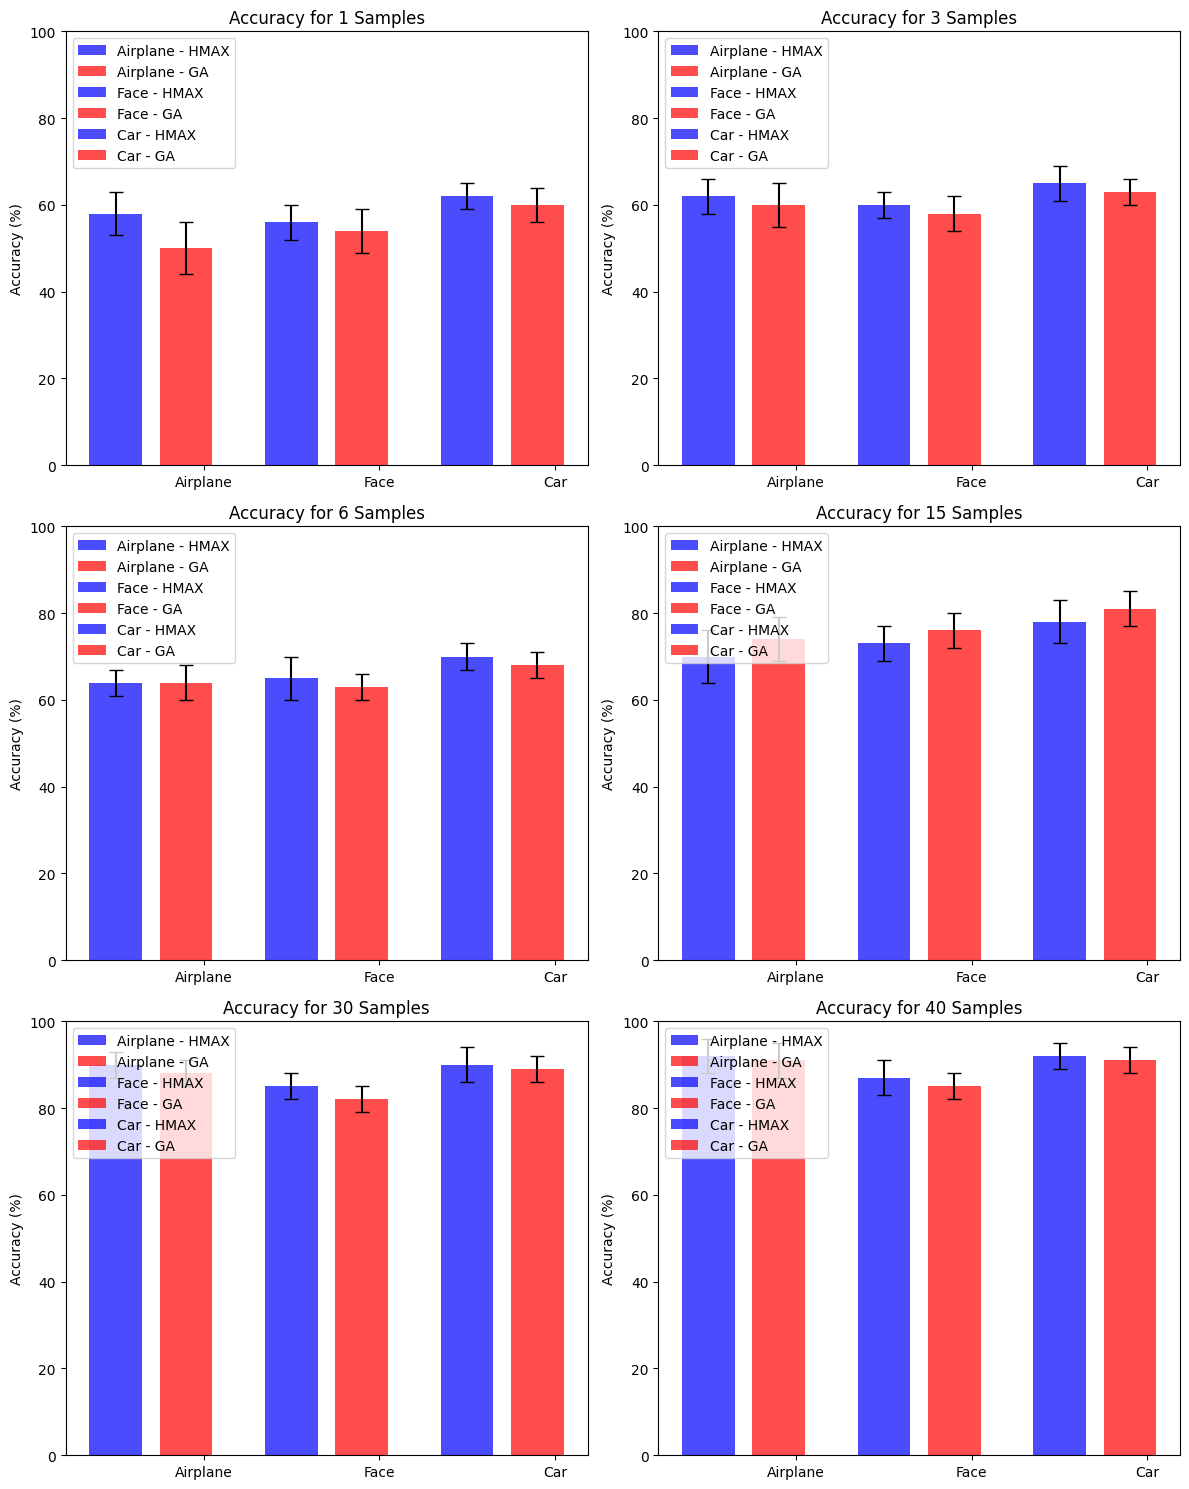

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
training_sizes = [1, 3, 6, 15, 30, 40]

# Airplane data
airplane_baseline = [58, 62, 64, 70, 90, 92]  # In percentage
airplane_optimized = [50, 60, 64, 74, 88, 91]  # In percentage

# Face data
face_baseline = [56, 60, 65, 73, 85, 87]
face_optimized = [54, 58, 63, 76, 82, 85]

# Car data
car_baseline = [62, 65, 70, 78, 90, 92]
car_optimized = [60, 63, 68, 81, 89, 91]

# Mock standard deviation values (for illustration)
airplane_baseline_std = [5, 4, 3, 6, 3, 4]
airplane_optimized_std = [6, 5, 4, 5, 3, 4]

face_baseline_std = [4, 3, 5, 4, 3, 4]
face_optimized_std = [5, 4, 3, 4, 3, 3]

car_baseline_std = [3, 4, 3, 5, 4, 3]
car_optimized_std = [4, 3, 3, 4, 3, 3]

# Function to create a plot for each image number (training size)
def plot_for_each_size_with_variance(training_sizes, airplane_baseline, airplane_optimized, face_baseline, face_optimized, car_baseline, car_optimized,
                                     airplane_baseline_std, airplane_optimized_std, face_baseline_std, face_optimized_std, car_baseline_std, car_optimized_std):
    bar_width = 0.3  # Width of each bar
    num_classes = 3  # Number of classes (Airplane, Face, Car)
    offset = bar_width
    spacing = 0.4

    fig, axs = plt.subplots(3, 2, figsize=(12, 15))
    axs = axs.flatten()

    for i, size in enumerate(training_sizes):
        ax = axs[i]

        positions = np.arange(num_classes)
        positions_for_HMAX_and_GA = positions - 0.5
        positions_for_GA = positions_for_HMAX_and_GA + spacing

        # Plot for the current image size with error bars (variance)
        ax.bar(positions_for_HMAX_and_GA[0], airplane_baseline[i], width=bar_width, label='Airplane - HMAX', color='blue', alpha=0.7,
               yerr=airplane_baseline_std[i], capsize=5)
        ax.bar(positions_for_GA[0], airplane_optimized[i], width=bar_width, label='Airplane - GA', color='red', alpha=0.7,
               yerr=airplane_optimized_std[i], capsize=5)

        ax.bar(positions_for_HMAX_and_GA[1], face_baseline[i], width=bar_width, label='Face - HMAX', color='blue', alpha=0.7,
               yerr=face_baseline_std[i], capsize=5)
        ax.bar(positions_for_GA[1], face_optimized[i], width=bar_width, label='Face - GA', color='red', alpha=0.7,
               yerr=face_optimized_std[i], capsize=5)

        ax.bar(positions_for_HMAX_and_GA[2], car_baseline[i], width=bar_width, label='Car - HMAX', color='blue', alpha=0.7,
               yerr=car_baseline_std[i], capsize=5)
        ax.bar(positions_for_GA[2], car_optimized[i], width=bar_width, label='Car - GA', color='red', alpha=0.7,
               yerr=car_optimized_std[i], capsize=5)

        # Set titles and labels
        ax.set_title(f'Accuracy for {size} Samples')
        ax.set_ylabel('Accuracy (%)')
        ax.set_xticks(positions)
        ax.set_xticklabels(['Airplane', 'Face', 'Car'])
        ax.set_ylim(0, 100)

        # Add a legend
        ax.legend(loc='upper left')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Plot for each training size (image number) with variance (error bars)
plot_for_each_size_with_variance(training_sizes, airplane_baseline, airplane_optimized, face_baseline, face_optimized, car_baseline, car_optimized,
                                 airplane_baseline_std, airplane_optimized_std, face_baseline_std, face_optimized_std, car_baseline_std, car_optimized_std)
